# Visualization of a Simple Stochastic Gradient Descent

Here we visualize the minimization of the loss with the SGD algorithm in its variants vanilla GD, batch SGD and minibatch SGD. For this we consider a linear model.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

## Dataset

Let's create a [PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). In PyTorch, the `Dataset` object is an abstract class from `torch.utils.data` that we subclass to create out own custom dataset. It defines how to access individual data samples and how many samples there are.

In [39]:
class LinearDataset(Dataset):
    '''The training data is generated from the linear
    function
              y = w * x + b  
    where `w` is the slope and `b` is the offset.
    Random noise in the range `[-0.1, 0.1]` is added
    to the function value `y`.
    '''

    def __init__(self, slope, offset, nsamples):
        self.w = slope
        self.b = offset
        self.nsamples = nsamples

        # A dedicated random number generator for the dataset
        self.rnd_gen_data = torch.Generator().manual_seed(1)
    
    def __getitem__(self, idx):
        x = torch.FloatTensor(1,).uniform_(-0.5, 0.5, generator=self.rnd_gen_data)
        y = self.w * x + self.b
        noise = torch.FloatTensor(1,).uniform_(-0.1, 0.1, generator=self.rnd_gen_data)
        return (x, y + noise)

    def __len__(self):
        return self.nsamples

We generate a random vector $x \in [-0.5, 0.5]$ and evaluate it in a linear function $y = 2w$ (we set the offset $b$ to be 0).
We add noise to $y$ and that gives us $y \in [-1.1, 1.1]$.

In [40]:
# Get a dataset and instantiated with a batch size of 128 --> each training step contains the 128 samples

train_set = LinearDataset(
    slope = 2.0,
    offset = 0.0,
    nsamples = 1500
)

train_loader = DataLoader(
    train_set,
    batch_size=128,
    shuffle=False,
    drop_last=True
)

In [41]:
# check how the batches look like
for x, y in train_loader:
    print(x.shape, y.shape)

torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1]) torch.Size([128, 1])


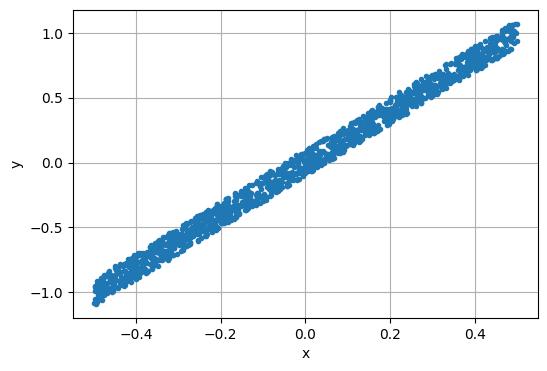

In [42]:
x_plot = []
y_plot = []
for x, y in train_loader:
    x_plot.append(x)
    y_plot.append(y)

x_plot = torch.cat(x_plot)
y_plot = torch.cat(y_plot)

plt.plot(x_plot, y_plot, '.')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

## Defining the model, a loss function and an optimizer

In [33]:
# Define the device (there are 4 in the group, and we choose now the first one)

device = 0   # First GPU

In [58]:
# Select a model: 
# Create a linear model with 1 input and 1 output (y = wx + b),
# and move it to the selected device
# provide 1 weight and 1 offset
model = torch.nn.Linear(1, 1, device=device)

# Select a loss function
loss_fn = torch.nn.MSELoss()

# Select an optimizer
# Define the optimizer for the loss function (gradient descent)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

## Training

In [59]:
def log(model, loss):
    """Utility function for plotting"""

    return(model.weight.item(),
           model.bias.item(),
           loss.item())

In [60]:
# how many times to show the data to the model for training
num_epochs = 50
history = []

for epoch in range(num_epochs):                 #   loop over epochs:
    # set a seed at each epoch to always        #
    # generate the same set of random x         #
    train_set.rnd_gen_data.manual_seed(1)       #
    #                                           #
    for x, y in train_loader:                   #      loop over batches:  -> (x, y)
        optimizer.zero_grad()                   #         * reset automatic differentiation record
        y_hat = model(x.to(device))             #         * evaluate the model in a batch -> y_hat (forward pass)
        loss = loss_fn(y_hat, y.to(device))     #         * evaluate the loss function with the obtained y_hat and y
        history.append(log(model, loss))        #         [not part of the traing] keep values for plotting later
        loss.backward()                         #         * backpropagation -> gradients
        optimizer.step()                        #         * update weights with the gradients

In [63]:
int(1000/128)*num_epochs

350

## Plots

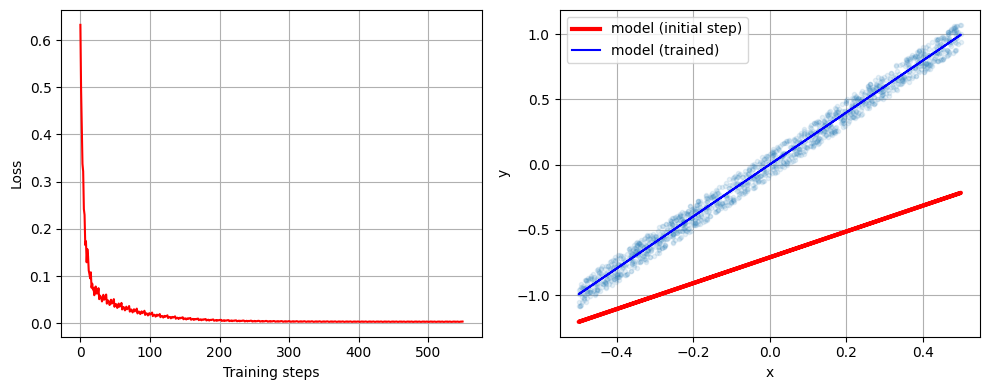

In [61]:
slope_hist  = np.array(history)[:, 0]
offset_hist = np.array(history)[:, 1]
loss_hist   = np.array(history)[:, 2]

matplotlib.rcParams['figure.figsize'] = (10, 4)

plt.subplot(1, 2, 1)
plt.plot(loss_hist, 'r-')
plt.xlabel('Training steps')
plt.ylabel('Loss')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(x_plot, y_plot, '.', alpha=.1)
plt.plot(x_plot, slope_hist[0]  * x_plot + offset_hist[0],  'r-', label='model (initial step)', lw=3)
plt.plot(x_plot, slope_hist[-1] * x_plot + offset_hist[-1], 'b-', label='model (trained)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

matplotlib.rcParams['figure.figsize'] = (6, 4)

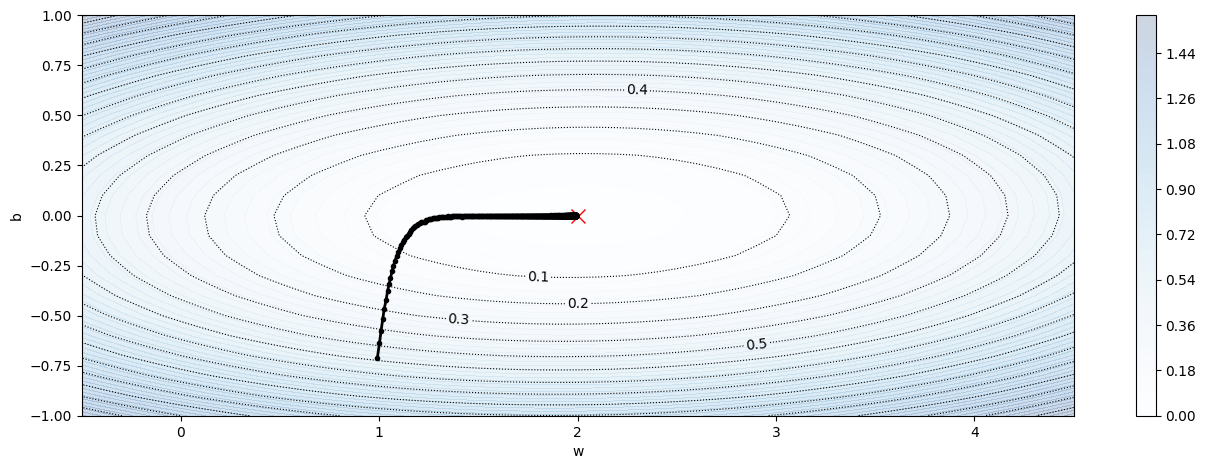

In [62]:
def loss_function_field(m, n, xref, yref):
    '''Utility function for ploting the loss'''
    return np.mean(np.square(yref - m * xref - n ))

_m = np.arange( -0.5, 4.51, 0.1)
_n = np.arange(-1., 1.01, 0.1)
M, N = np.meshgrid(_m, _n)

Z = np.zeros(M.shape)
for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        Z[i, j] = loss_function_field(M[i, j], N[i, j],
                                      x_plot.numpy(), y_plot.numpy())

matplotlib.rcParams['figure.figsize'] = (16.0, 5.2)

cp = plt.contour(M, N, Z, 16, vmin=Z.min(), vmax=Z.max(), alpha=0.99, colors='k', linestyles=':', linewidths=0.8)
plt.contourf(M, N, Z, 60, vmin=Z.min(), vmax=Z.max(), alpha=0.2, cmap='Blues')  #plt.cm.RdYlBu_r)
plt.clabel(cp, cp.levels[:6])
plt.colorbar()
m = slope_hist[-1]
n = offset_hist[-1]
plt.plot([train_set.w], [train_set.b], 'rx', ms=10)
plt.plot(slope_hist, offset_hist, '.-', lw=2, c='k')
plt.xlim([_m.min(), _m.max()])
plt.ylim([_n.min(), _n.max()])
plt.xlabel('w')
plt.ylabel('b')
plt.show()

matplotlib.rcParams['figure.figsize'] = (6, 4)

### Exercises

1. Try different batch sizes and see the effect path of the SGD:
 * `batch_size = 1000` - The whole dataset
 * `batch_size = 128`  - Something between 1 and the size of the whole dataset
 * `batch_size = 1`    - This is perhaps too slow. Maybe try a smaller batch size, such as 16

2. Why is the training with `batch_size = 1` so slow compared to `batch_size = 128`?
3. Try different learning rates and see how the path of the SGD looks like.

### Discussion

Changing batch sizes:

- Whole dataset: Only one step per epoch. The training does not go towards minimum. It does not make it until the minimum whithin the given epochs (25). Increasing the epochs solves this. The gradient is evaluated with the same data, resulting in a smooth loss functions

- Lower batchsizes: Many more steps per epoch. The training might get to the minimum within less epochs. The loss function may fluctuate, which might avoid getting stuck at local minima, and "explore" a bit.

- Choice of a batch size should be iterative, reching a "sweet spot" for fast computation and fast convergence

Changing learning rate:

- Increasing it might make the swings towards the minima larger, creating oscillations
- Decreasing it will make the change very small, will make it slower, but smoother without oscillations


### Changing batch_sizes
When using mini-batch gradient descent the following applies:

- 1 epoch = N/n iterations, with N is the number of observations int he dataset and n is the batch size

Thus, increasing the batch size to N results in 1 epoch = 1 iteration

Then, decreasing the batch size to 1 results in 1 epoch = N iterations

Decreasing results in the model evaluating the subsets more time (n/N) times --> more evaluation --> longer training
Increasing the batch size does the opposite



### Changing the learning rate

Decreasing it makes the path towards the global minimum smoother, but does not reach the global min within the given iterations

Increasing it seems to make the initial change much larger

### Technical check

By this point, you should be comfortable with the following:
 * Explaining what a batch is and why batching is important in training neural networks.
 * Explaining what's the learning rate and its effect on the training.
 * Implementing a custom Dataset and wraping it in a DataLoader using PyTorch.
 * Transfering data to GPU memory using `.to(device)` for faster computation.
 * Instantiating a model, defining a loss function, and setting up an optimizer in PyTorch.
 * Writing a full training loop that iterates over batches, computes loss, and updates model parameters.